# **Decomposition of time series. Stationarity and trend**

In [1]:
!git clone https://github.com/Astralex98/MOSD_2023.git

Cloning into 'MOSD_2023'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (17/17), 6.48 MiB | 9.07 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
%cd MOSD_2023/Seminar_2

/content/MOSD_2023/Seminar_2


In [3]:
!pwd

/content/MOSD_2023/Seminar_2


## Dependencies

In [4]:
! unzip data.zip -d .

Archive:  data.zip
   creating: ./data/
  inflating: ./data/mauna_loa_atmospheric_c02.csv  
   creating: ./figures/
  inflating: ./figures/in-sample.png  
  inflating: ./figures/ts-k-fold.png  


In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels as sm
import statsmodels.api

from tqdm import tqdm

In [6]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### А. Downloading and vizualization of data

Let's load time series of the concentration of $CO_2$ in the atmosphere (based on data [from here](https://www.co2.earth/weekly-co2))

In [7]:
dataset = pd.read_csv("./data/mauna_loa_atmospheric_c02.csv",
                      index_col=None, usecols=["date", "WMLCO2"])

In [8]:
dataset.head()

,date,WMLCO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


When loading a time series in Pandas, you must explicitly indicate the need
converting date-time stamps from text to date-time format.

* This can also be specified when calling `pd.read_csv`

In [9]:
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y-%m-%d")

Rename columns

In [10]:
dataset = dataset.rename(columns={"date": "data", "WMLCO2": "concentration CO2"})

In [11]:
dataset.head()

,data,concentration CO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


Let's create an index for the loaded data: this will be **weekly periodic index**

We will get data with a regular frequency.

In [12]:
dataset = dataset.set_index("data").to_period("W")

In [13]:
dataset.head()

,concentration CO2
data,
1958-03-24/1958-03-30,316.1
1958-03-31/1958-04-06,317.3
1958-04-07/1958-04-13,317.6
1958-04-14/1958-04-20,317.5
1958-04-21/1958-04-27,316.4


Plot dynamic of series

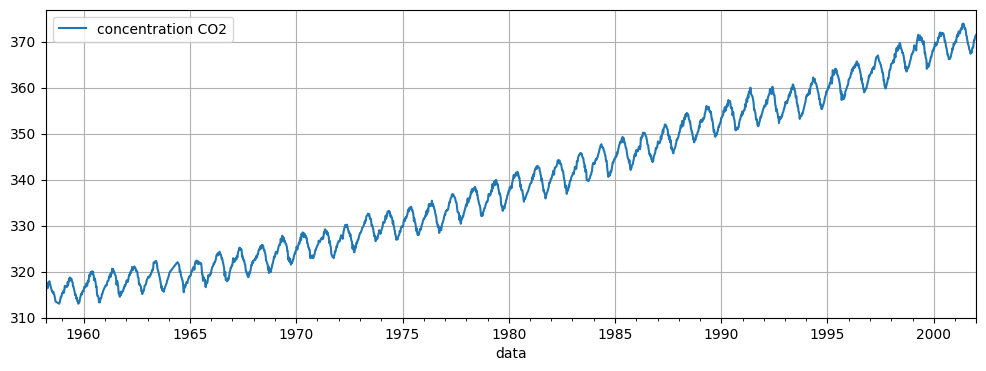

In [14]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

Aggregate weekly data to monthly

In [15]:
dataset = dataset.to_timestamp()

dataset = dataset.resample("M").mean()

In [16]:
dataset.head()

,concentration CO2
data,
1958-03-31,316.700
1958-04-30,317.100
1958-05-31,317.700
1958-06-30,315.800
1958-07-31,315.575


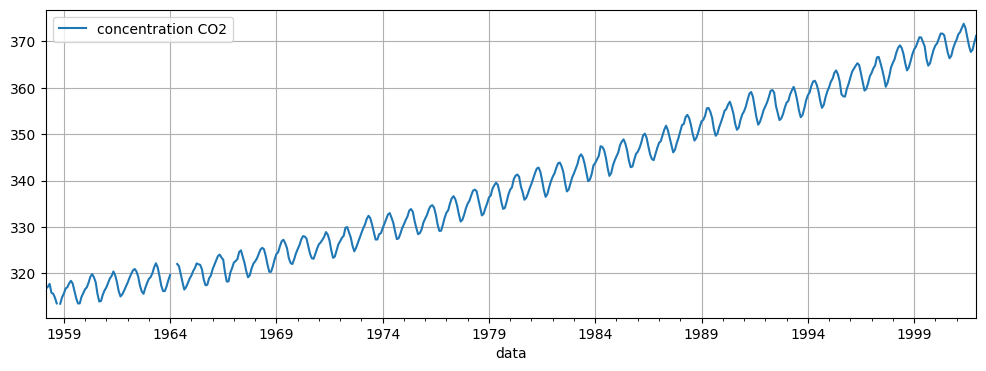

In [17]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

Let's look at the summary statistics of the series:

In [18]:
print("Series {1}, Observations {0}".format(*dataset.shape))

dataset.describe().T.head()

Series 1, Observations 526


,count,mean,std,min,25%,50%,75%,max
concentration CO2,522.0,339.794055,17.090851,313.425,324.185,337.9825,354.545,373.825


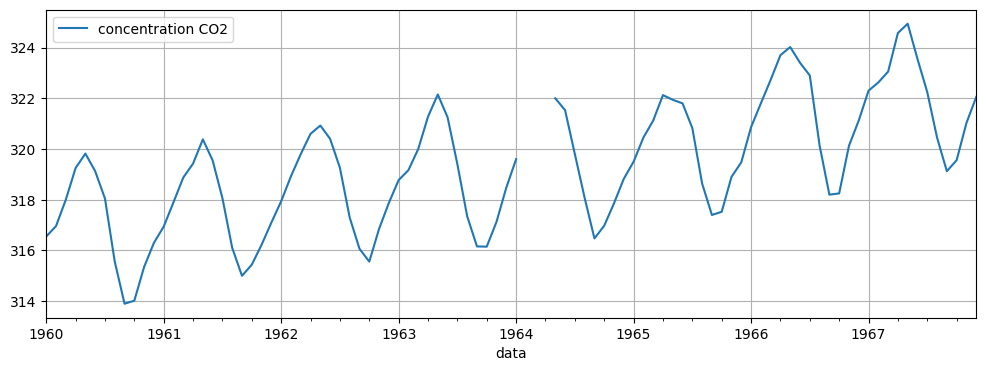

In [19]:
dataset.loc["1960":"1967"].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

#### В. Filling missing values

In [20]:
maginfy_slice = slice("1960", "1967")

You can get rid of missing values ​​in time series:

1) Filling in with the last known value:

Let's choose the `ffill` method to extrapolate the previous value of the series to the place of gap. Other standard filling methods can be selected, see the `Ctrl` +` Tab` function help

In [21]:
dataset_ff = dataset.ffill()

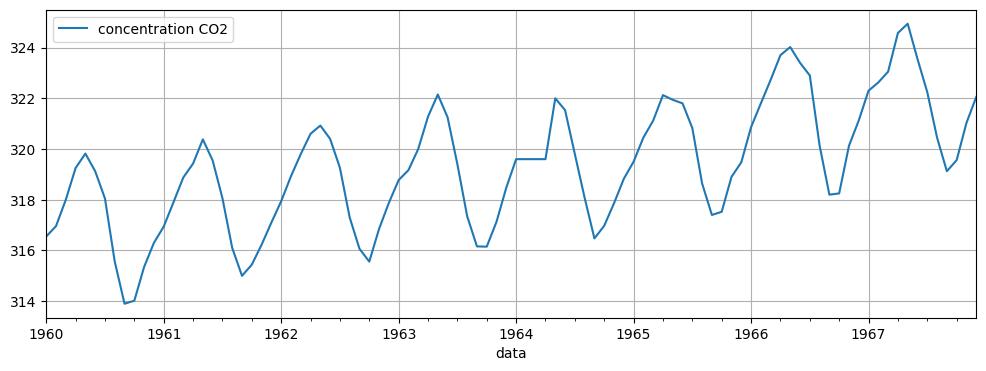

In [22]:
dataset_ff.loc[maginfy_slice].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

2) By interpolating adjacent observed values:

In [23]:
dataset_linterp = dataset.interpolate(method = "linear")
dataset_pinterp = dataset.interpolate(method='polynomial', order=2)

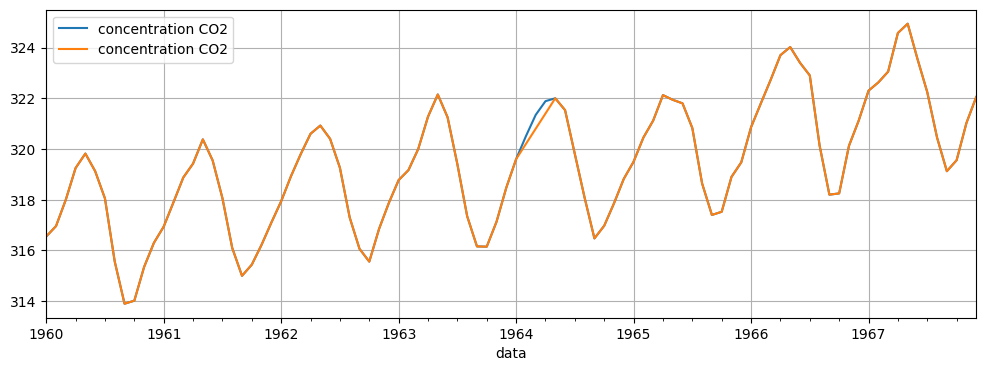

In [24]:
ax = dataset_pinterp.loc[maginfy_slice].plot(figsize=(12, 4))

dataset_linterp.loc[maginfy_slice].plot(ax=ax)

plt.grid(which="major", axis="both")

3) Exclude all missing values from the sample:

In [25]:
dataset_drop = dataset.dropna()

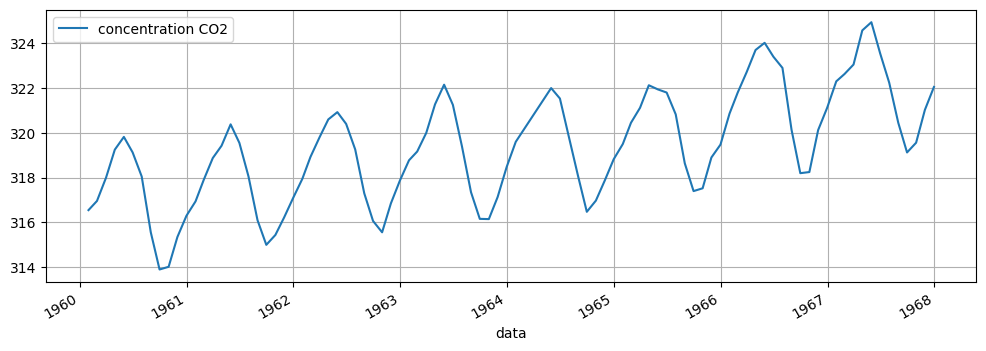

In [26]:
dataset_drop.loc[maginfy_slice].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

4) Evaluate with a probabilistic model:

5) Smooth by splines or local model with kernel:

The problem of "looking" into the future in methods 2 and 4 **can be neglected if there are few missing values**.

* <span style = "color: red;"> ** IMPORTANT ** </span> If there are a lot of them, then you need to answer the question about the reasons for the missing values.

In [27]:
dataset_pinterp = dataset.interpolate(method='polynomial', order=2)
full_dataset = dataset_pinterp

 ### C. Preparation of test and train samples

Prepare train and test sample in proportion 3:1

In [28]:
#TODO: Try another splitting. How the result depends on train_size?

holdout = full_dataset.loc["1991-01-01":]

dataset = full_dataset.loc[:"1990-12-31"]

print(len(dataset), len(holdout))

394 132


Make sure the parts don't overlap

In [29]:
pd.concat([
    dataset.tail(),
    holdout.head()
], axis=1)

,concentration CO2,concentration CO2
data,,
1990-08-31,352.250,NaN
1990-09-30,350.950,NaN
1990-10-31,351.400,NaN
1990-11-30,353.075,NaN
1990-12-31,354.260,NaN
1991-01-31,NaN,354.925
1991-02-28,NaN,355.950
1991-03-31,NaN,357.400
1991-04-30,NaN,358.700


Explicitly preserve the boundaries of the segments

In [30]:
holdout_slice = slice(*holdout.index[[0, -1]])

print("Train sample from {} to {}".format(*dataset.index[[0, -1]]))

print("Test sample from {} to {}".format(holdout_slice.start, holdout_slice.stop))

Train sample from 1958-03-31 00:00:00 to 1990-12-31 00:00:00
Test sample from 1991-01-31 00:00:00 to 2001-12-31 00:00:00


Choose a column

In [31]:
target_column = "concentration CO2"

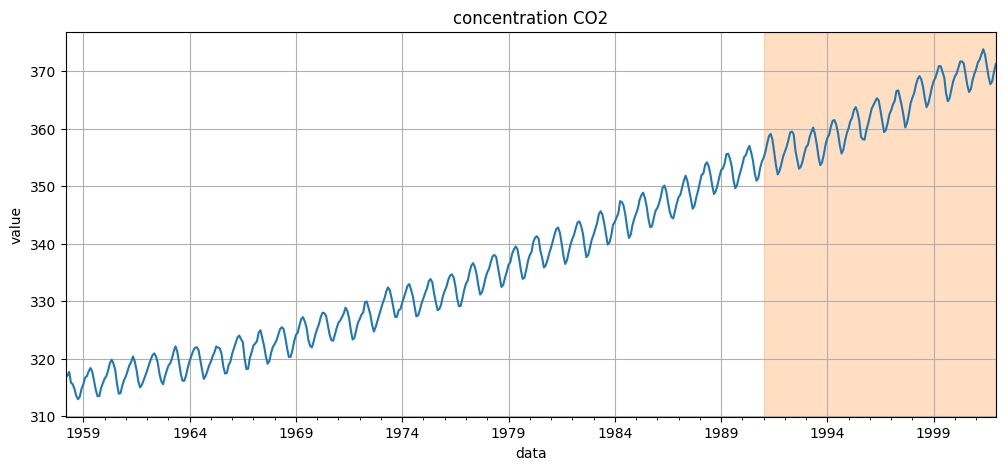

In [32]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plote dynamic of the whole series
full_dataset[target_column].plot(ax=ax)

# darkening delayed interval
ax.axvspan(holdout_slice.start, holdout_slice.stop,
           color="C1", alpha=0.25, zorder=-99)

ax.grid(which="major", axis="both") ;


<br>

## 2.  Detecting stationarity

**Stationarity** -- useful property of the process $ \{y_t \} _ {t \geq0} $, which means that:
> the probabilistic relationships in the set $ (y_ {t_1}, \, \ldots, \, y_ {t_m}) $ are exactly the same as
in $ (y_ {t_1 + s}, \, \ldots, \, y_ {t_m + s}) $, for any shift $ s \neq 0 $.

* no **special moments of time** when the statistical properties of observations change;

* patterns are stable in time and are determined only by **offset of observations relative to each other**;
  * mean, variance and autocorrelations do not depend on the moment in time;

### Stationarity - property, ... that does not exist

Stochastic process encountered in real problems **are almost always nonstationary**.

* the average value depends on time (there is a trend in the dynamics)
  - steady GDP growth
  - decrease in production in the well
  - dependence on external factors (exogenous variables)

* calendar events
  - state and religious holidays

* seasonal frequency
  - intraday cyclicity of electricity consumption
  - seasonal temperatures
  - annual peak of monthly inflation in January-February

* periods of calm dynamics are replaced by periods of relatively high volatility
  - strong disturbances in financial markets during the crisis

* unpredictable structural shifts and market changes
  - political decisions
  - equipment failures
  - hysteresis

Accordingly, most time series, especially economic, climatic and financial ones, **are non-stationary.**

<br>

#### Visualization and diagnostics of nonstationarity

Visualization in time series analysis allows you to:

- get a preliminary idea of the correlation patterns

- choose an appropriate validation strategy

- estimate if there are structural changes in the dynamics of a number
  * spikes and drops
  * accumulations of intense vibrations and periods of smooth movements

- to diagnose non-stationarity: the presence of a trend, seasonality, etc.

###   А. Moving characteristics

The sliding statistics of the series in the $N$ length window make it clear whether there are changes over time

* **moving average:** average level of series
$$
    m_t = \frac1{N} \sum_{s=t-N+1}^t y_s
\,; $$

* **moving standard deviation:** spread or volatility
$$
    s_t = \sqrt{s^2_t}
        \,, \quad
    s^2_t = \frac1{N-1} \sum_{s=t-N+1}^t (y_s - m_t)^2
\,; $$

Below is a procedure for conveniently plotting diagnostic graphs.

In [33]:
def rolling_diagnostics(series, window=500):
    rolling = series.rolling(window)

    # Create and set plots: upper and down
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Moving average", xlabel="Data", ylabel="value")
    ax_bottom = fig.add_subplot(212, title="Moving stdv",
                                sharex=ax_top, xlabel="Data", ylabel="stdv")

    # plot graphs:
    # serries and moving average


    rolling_mean = rolling.mean()
    rolling_mean.plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # moving standard deviation
    rolling_std = rolling.std()
    rolling_std.plot(ax=ax_bottom)
    ax_bottom.grid(which="major", axis="both")

    fig.tight_layout()
    return fig

From the graphs of moving statistics, we can suggest that there is a trend in the dynamics of values.

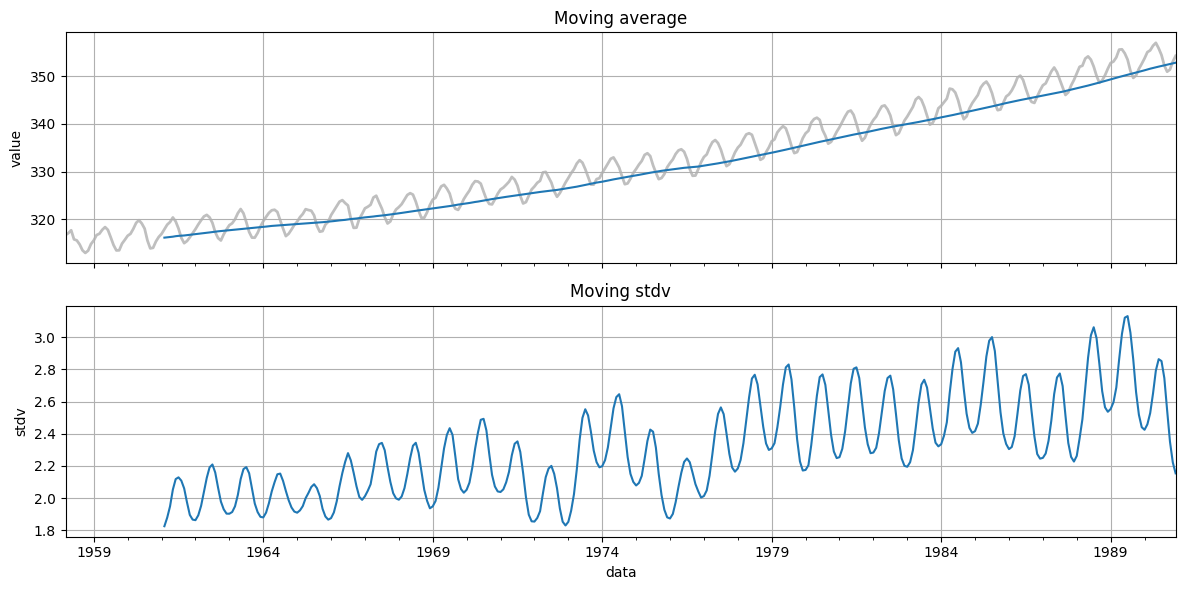

In [34]:
rolling_diagnostics(dataset[target_column], window=36);

<br>

### Rough estimate of seasonality

You can try researching seasonality, such as monthly or weekly.

* when assessing seasonality, it is desirable that seasonal adjustments are made relative to the trend.

In [35]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period="month"):
    # use nonparametric local linear regression to estimate the trend
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # let's group by month and calculate the average and std. deviation
    by = getattr(series.index, period, "month")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # create and plot graphs: upper and down
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Trend", xlabel="Data")
    ax_bottom = fig.add_subplot(212, title="Seasonality", xlabel=period)

    # plot graphs
    # series and trend
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # seasonality and 90% confidence interval
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig

Plots shows seasonality in dynamics

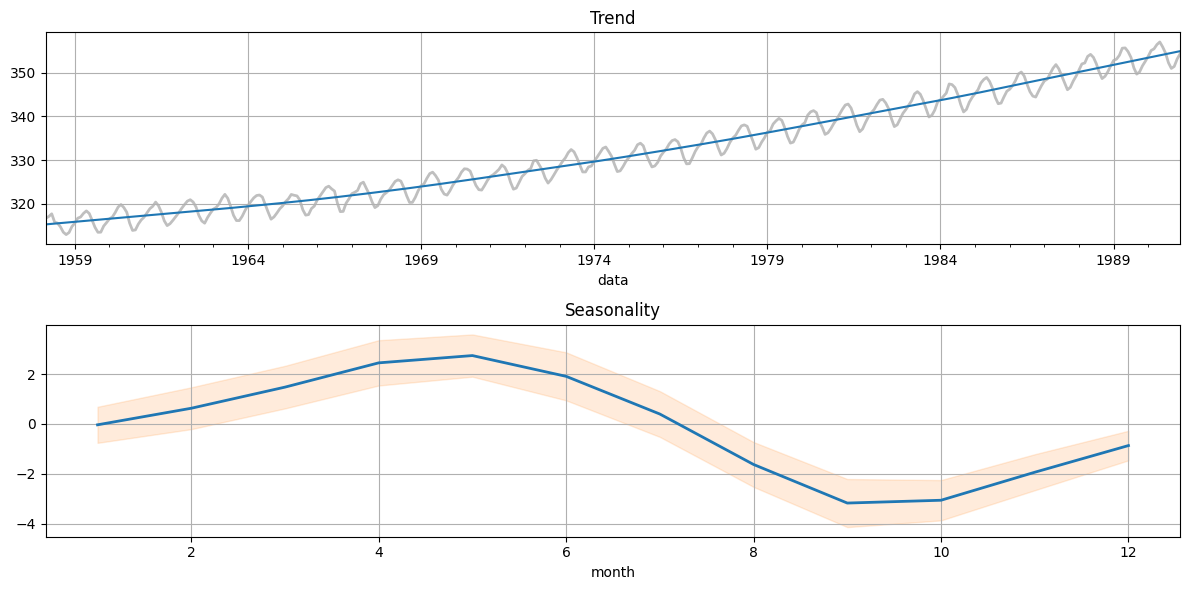

In [36]:
monthly_seasonality_diagnostics(dataset[target_column], fraction=0.33, period="month");

<br>

### B. Correlation analysis

#### Full and partial autocorrelation

These functions estimate the impact of observing $ h $ steps on the current observation, however, they do it in different ways:

* **full autocorrelation** $ \rho_h $ <!--  ($ y_t \sim y_ {t-h} $) -->
  - reflects the **cumulative** effect of $ y_ {th} $ on $ y_t $ **through** the effect on all intermediate $ y_ {tj} $, $ j = 1, \, ..., \, h-1 $

* **partial autocorrelation** $ \phi_h $ <!-- ($ y_t \sim y_ {t-1}, \ldots, y_ {t-h} $) ->
  - shows **pure** effect of $ y_ {t-h} $ on $ y_t $ **excluding** the effect on intermediate $ y_ {t-j} $, $ j = 1, \, ..., \, h-1 $

In [37]:
from statsmodels.tsa.stattools import acf, pacf

Below is a procedure for conveniently plotting diagnostic graphs.

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def correlation_diagnostics(series, lags=60):
    # create and set plots: left and right
    fig = plt.figure(figsize=(12, 3))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={"xlabel": "Lag", "ylim": (-1.1, 1.1)})

    # Plot graphs using built-in functions from statsmodels
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title="Sample Autocorrelation", marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title="Sample Partial Autocorrelation", marker=None)

    fig.tight_layout()
    return fig

Let's study selective autocorrelation of our series

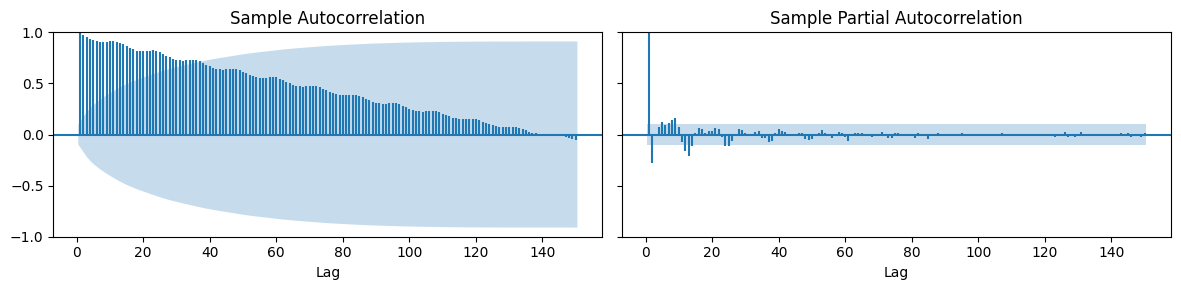

In [39]:
correlation_diagnostics(dataset[target_column], lags=150);

* on the *left graph* autocorrelation of small lags is close to $ 1.0 and decreases rather slowly
* on the *right graph* a statistically non-zero net effect is observed for an observation with a lag of 1

These are symptoms of the most typical type of nonstationarity - the so-called. the presence of a dependency of the form $ y_t = y_ {t-1} + \ldots $.

This means that there is a strong dependence on the history of the process.

### C.  Testing hypotheses for stationarity of processes.

In [40]:
# TODO: explore the world of hypothesis testing:)

#### Statistical diagnostics of trails of nonstationarity

Time series distinguish two types of trend

* **deterministic** (determenistic trend, unit root) - when noise or time deviations do not affect the values ​​in the long term

* **stochastic** (stochastic trend) - noise or unexpected shocks affect the entire future trajectory

For example, linear trends
\begin{aligned}
    & \text{Trend}
      & & \text{levels}
          & & \text{diff}
        \\
    & \text{deterministic}
      & y_t
        &= y_1 + \delta \, t + \varepsilon_t
          & & y_t - y_{t-1} = \delta + \varepsilon_t-\varepsilon_{t-1}
    \,, \\
    & \text{stochastic}
      & y_t
        &= y_1 + \delta \, t + \sum_{s=1}^t \varepsilon_s
          & & y_t - y_{t-1} = \delta + \varepsilon_t
    \,,
\end{aligned}

#### KPSS

If there is a suspicion of a **deterministic** linear trend, the **KPSS** test can be applied:
the hypothesis $ H_0 \colon \sigma ^ 2 = 0 $ in the model is tested
$$
    y_t = \alpha + \beta t + u_t + \nu_t
        \,, \quad
    u_t = u_{t-1} + \varepsilon_t
        \,, \quad
    \varepsilon_t \sim D(0, \sigma^2)
\,. $$

In [41]:
from statsmodels.tsa.stattools import kpss

#### ADF

If the trend appears to be **stochastic**, then the Augmented Dickey-Fuller test is applied.
unit root test): the hypothesis $ H_0 \colon \gamma = 0 $ in the model is tested
$$
    \Delta y_t
        = \beta + \gamma y_{t-1}
            + \sum_{k=1}^{p-1} \phi_k \Delta y_{t-k}
            + \varepsilon_t
\,, $$

where $ \Delta y_t = y_t - y_{t-1} $ are the first differences.

Alternatively, you can use the Phillips-Perron test.

In [42]:
from statsmodels.tsa.stattools import adfuller

\begin{aligned}
    & \text{ - }
      & & \text{ADF doesn't reject $H_0$ }
          & & \text{ADF reject $H_0$ }
    \,,    \\
    & \text{KPSSdo not reject $H_0$ }
      & & \text{Not enough data *}
          & & \text{Deterministic trend}
    \,, \\
    & \text{KPSS reject $H_0$ }
      & & \text{Stochastic trend}
          & & \text{ ** }
    \,,
\end{aligned}

<!-- [Four cases](https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests/239367) --
<!--http://web.econ.ku.dk/metrics/Econometrics2_05_II/Slides/08_unitroottests_2pp.pdf-->

\* Better, just in case, to take the first difference (there may be high persistence).

** It can be anything: seasonality, heteroscedasticity, structural shifts, weak but non-zero stochastic trend.

A procedure that returns test statistics and the corresponding $ p $ -value

In [43]:
def stat_test_diagnostics(series):
    return {
        "ADF": adfuller(series, regression="ct")[:2],
        "KPSS": kpss(series, regression="c")[:2],
    }

In [44]:
stat_test_diagnostics(dataset[target_column])

<ipython-input-43-370941381fc0>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  "KPSS": kpss(series, regression="c")[:2],


{'ADF': (-1.5871756923514098, 0.7974141230613575),
 'KPSS': (3.336296447917031, 0.01)}

All diagnostics in one procedure:

In [45]:
def diagnostics(series, window=250, fraction=0.25, lags=150):
    # moving statistics
    rolling_diagnostics(series, window=window)
    plt.show()
    plt.close()

    # rough seasonality
    monthly_seasonality_diagnostics(series, fraction=fraction)
    plt.show()
    plt.close()

    # autocorrelation
    correlation_diagnostics(series, lags=lags)
    plt.show()
    plt.close()

    return stat_test_diagnostics(series)

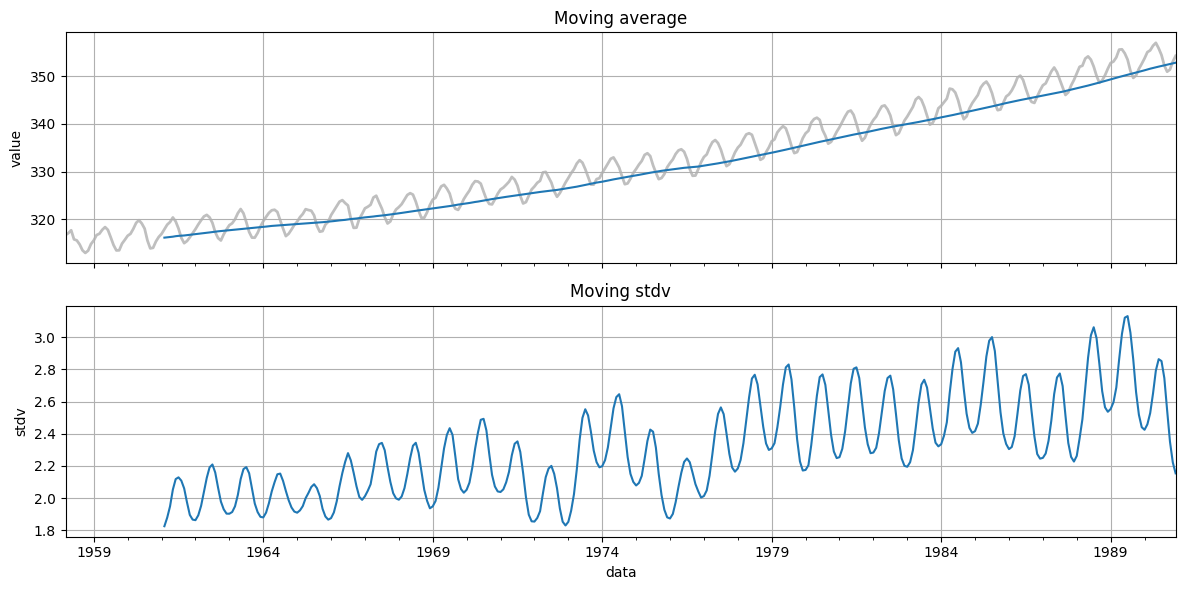

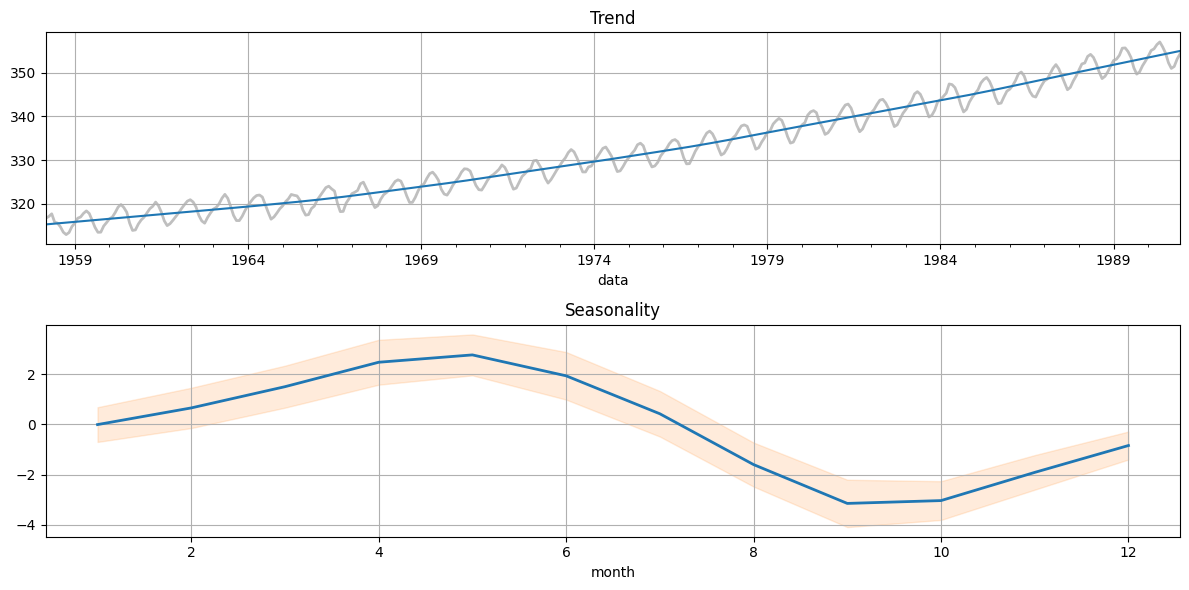

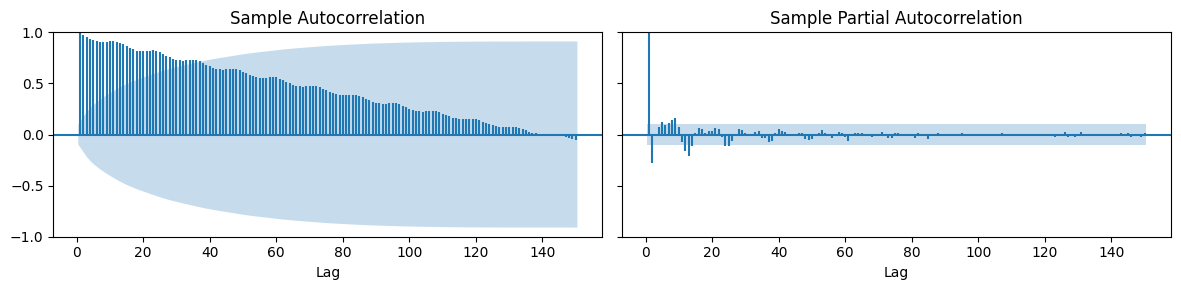

<ipython-input-43-370941381fc0>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  "KPSS": kpss(series, regression="c")[:2],


{'ADF': (-1.5871756923514098, 0.7974141230613575),
 'KPSS': (3.336296447917031, 0.01)}

In [46]:
diagnostics(dataset[target_column], window=36)

### Problem

**Without stationarity** it is very difficult to model the series

* no stable invariant patterns suitable for modeling and forecasting

### What to do?

In time series analysis, everything is exactly the same as with optimization problems.
* successfully solved problems of **convex** programming
* but all interesting practical problems are **non-convex**

If **bring** the series as close as possible to the stationary one, **taking into account the trend, seasonality and other spoiling factors**
then **we can hope for** more or less successful **modeling and solution** of applied problems.

<br>